<!-- @format -->

# SMAPE Error Analysis Notebook

This notebook analyzes the Symmetric Mean Absolute Percentage Error (SMAPE) for the PriceVision model's predictions. It examines error patterns across different price buckets and text characteristics to identify areas for model improvement.


<!-- @format -->

## Setup and Imports

This section imports necessary libraries, sets up the Python path, and loads custom modules for SMAPE calculation, validation splitting, model building, and configuration.


In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Add parent directory to path for module imports
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

# Import custom SMAPE metric
from metrics.smape import smape
# Import validation split function
from utils.validation import create_validation_split
# Import TF-IDF Ridge model builder
from models.tfidf_ridge import build_tfidf_ridge
# Import target column configuration
from config import TARGET_COL

<!-- @format -->

## Data Loading and Preprocessing

This section loads the training data, creates a combined text column, and performs stratified train/validation splitting.


In [9]:
# Load training data from CSV
df = pd.read_csv("../data/train.csv")

# Create combined text column from catalog content, handling missing values
df["text"] = df["catalog_content"].fillna("")

# Create stratified train/validation splits based on price buckets
train_df, val_df = create_validation_split(df, TARGET_COL)

<!-- @format -->

## Model Training and Prediction

This section trains the baseline TF-IDF + Ridge regression model on the training data and generates predictions on the validation set.


In [14]:
from sklearn.pipeline import Pipeline

# Prepare features and targets
X_train = train_df["text"].values
X_val = val_df["text"].values

# Scaled Log-transform target for training (common for price prediction)
y_train = np.log1p(train_df[TARGET_COL].values)
y_val = val_df[TARGET_COL].values

# Build and train TF-IDF Ridge model
model = build_tfidf_ridge()
model.fit(X_train, y_train)

# Generate predictions and inverse log-transform
val_pred = np.expm1(model.predict(X_val))

# SMAPE safety clipping
low = np.percentile(train_df[TARGET_COL].values, 1)
high = np.percentile(train_df[TARGET_COL].values, 99)

val_pred = np.clip(val_pred, low, high)

# Post-prediction bias correction
bucket_medians = train_df.groupby("price_bucket")[TARGET_COL].median()

def bias_correct(row):
    b = row["price_bucket"]
    if b == 0:
        return row["pred"] * 0.85   # reduce over-prediction
    elif b == 4:
        return row["pred"] * 1.15   # increase under-prediction
    return row["pred"]

val_df["pred"] = val_pred
val_df["pred"] = val_df.apply(bias_correct, axis=1)
val_pred = val_df["pred"].values

<!-- @format -->

## Error Calculation

This section calculates absolute errors and SMAPE (Symmetric Mean Absolute Percentage Error) for each validation sample.


In [15]:
# Attach predictions and errors to validation dataframe
val_df = val_df.copy()

val_df["pred"] = val_pred
val_df["abs_error"] = np.abs(val_df["pred"] - val_df[TARGET_COL])

# Calculate SMAPE for each item (Symmetric Mean Absolute Percentage Error)
val_df["smape_item"] = (
    np.abs(val_df["pred"] - val_df[TARGET_COL]) /
    ((np.abs(val_df["pred"]) + np.abs(val_df[TARGET_COL])) / 2 + 1e-6)
) * 100

<!-- @format -->

## Worst Predictions Analysis

This section identifies and displays the validation samples with the highest SMAPE errors to understand model weaknesses.


In [16]:
# Display the 20 worst predictions by SMAPE
val_df.sort_values("smape_item", ascending=False).head(20)[
    ["catalog_content", TARGET_COL, "pred", "smape_item"]
]

,catalog_content,price,pred,smape_item
18709,Item Name: Nescaf Clasico Decaf Instant Coffee...,286.77,5.912556,191.919495
4923,"Item Name: Sour Patch Kids, 2-Ounce Bags (Pack...",444.85,13.036151,188.611884
28165,Item Name: Donettes Single Serve Crunch Mini D...,1.68,52.864323,187.679738
47257,Item Name: Jenny Silks White Real Touch Phalae...,496.28,18.573105,185.570171
86,Item Name: Tory Burch Coco Ginger Shortbread S...,298.00,11.786191,184.781514
25271,Item Name: Cocoa Classics French Vanilla Cocoa...,0.72,17.960400,184.582751
13118,"Item Name: Dolores Tuna in Chipotle Sauce, 5 O...",84.74,3.651314,183.476591
11277,"Item Name: Embasa Salsa Mexicana, 7 Ounce\nBul...",51.63,2.251878,183.282846
12615,"Item Name: Smartfood Popcorn, White Cheddar 5/...",0.49,10.928107,182.834251
4214,Item Name: Cocoa Classics Caramel Cocoa Mix | ...,0.78,15.447354,180.773183


<!-- @format -->

## Bucket-wise Error Distribution

This section analyzes SMAPE error patterns across different price buckets to identify if the model performs differently for various price ranges.


Bucket 0 | Mean SMAPE: 69.74769367204242
Bucket 1 | Mean SMAPE: 44.34180949143867
Bucket 2 | Mean SMAPE: 33.665867368954885
Bucket 3 | Mean SMAPE: 44.5196016894801
Bucket 4 | Mean SMAPE: 64.38119388713537


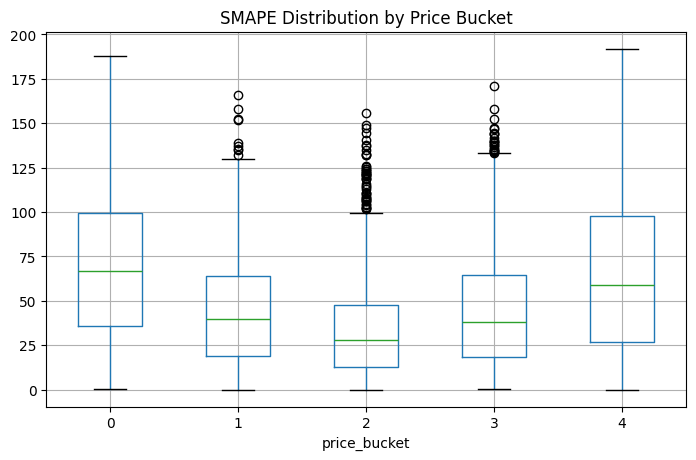

In [17]:
# Analyze SMAPE distribution across price buckets
import matplotlib.pyplot as plt

for bucket in sorted(val_df["price_bucket"].unique()):
    subset = val_df[val_df["price_bucket"] == bucket]
    print(
        f"Bucket {bucket} | Mean SMAPE:",
        subset["smape_item"].mean()
    )

# Create boxplot to visualize SMAPE distribution by bucket
val_df.boxplot(
    column="smape_item",
    by="price_bucket",
    figsize=(8, 5)
)
plt.title("SMAPE Distribution by Price Bucket")
plt.suptitle("")
plt.show()

<!-- @format -->

## Text Length vs Error Analysis

This section explores the relationship between text length and prediction error to see if longer or shorter descriptions correlate with model performance.


<Axes: xlabel='text_len', ylabel='smape_item'>

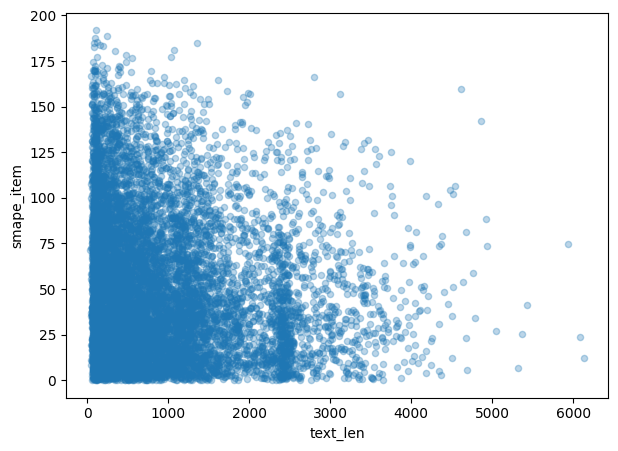

In [18]:
# Calculate text length for each sample
val_df["text_len"] = val_df["catalog_content"].str.len()

# Create scatter plot of text length vs SMAPE error
val_df.plot.scatter(
    x="text_len",
    y="smape_item",
    alpha=0.3,
    figsize=(7, 5)
)

<!-- @format -->

## Additional Analysis

This section can be used for any additional error analysis or model diagnostics.


In [8]:
# Add any additional analysis code here